# Projeto de Análise de Crédito

Para este projeto, estaremos explorando dados disponíveis publicamente de [LendingClub.com](www.lendingclub.com). Lending Club conecta pessoas que precisam de dinheiro (mutuários) com pessoas que têm dinheiro (investidores). Felizmente, como investidor, você gostaria de investir em pessoas que mostraram um perfil de ter uma alta probabilidade de pagá-lo de volta. Vamos tentar criar um modelo que ajude a prever isso.

O clube de empréstimo teve um [ano muito interessante em 2016](https://en.wikipedia.org/wiki/Lending_Club#2016), então vamos verificar alguns de seus dados e ter em mente o contexto. Esses dados são de antes mesmo de serem públicos.

Utilizaremos os dados de empréstimos de 2007-2010 e tentaremos classificar e prever se o mutuário pagou o empréstimo na íntegra.

Mapeamento das colunas:
* credit.policy: 1 se o cliente atender aos critérios de subscrição de crédito da LendingClub.com e 0 caso contrário.
* purpose: O objetivo do empréstimo (possíveis valores "credit_card", "debt_consolidation", "educacional", "major_purchase", "small_business" e "all_other").
* int.rate: a taxa de juros do empréstimo. Os mutuários julgados por LendingClub.com para serem mais arriscados recebem taxas de juros mais elevadas.
* installment: as parcelas mensais devidas pelo mutuário se o empréstimo for financiado.
* log.annual.inc: O log natural da renda anual auto-relatada do mutuário.
* dti: Ratio dívida / rendimento do tomador do empréstimo (montante da dívida dividido pela receita anual).
* fico: a pontuação de crédito FICO do mutuário.
* days.with.cr.line: O número de dias em que o mutuário teve uma linha de crédito.
* revol.bal: Saldo rotativo do mutuário (montante não pago no final do ciclo de cobrança do cartão de crédito).
* revol.util: taxa de utilização da linha rotativa do mutuário (o valor da linha de crédito usada em relação ao crédito total disponível).
* inq.last.6mths: número de consultas do mutuário por credores nos últimos 6 meses.
* delinq.2yrs: o número de vezes que o mutuário havia passado mais de 30 dias em um pagamento nos últimos 2 anos.
* pub.rec: O número de registros públicos depreciativos do mutuário (arquivamentos de falências, ônus fiscais ou julgamentos).

# Libraries

In [4]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

## Data review

In [5]:
df_loan = pd.read_csv("loan_data.csv")

** Use os métodos info(), head(), e describe() em loans. **

In [6]:
df_loan.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [7]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [8]:
df_loan.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


# Análise exploratória de dados 


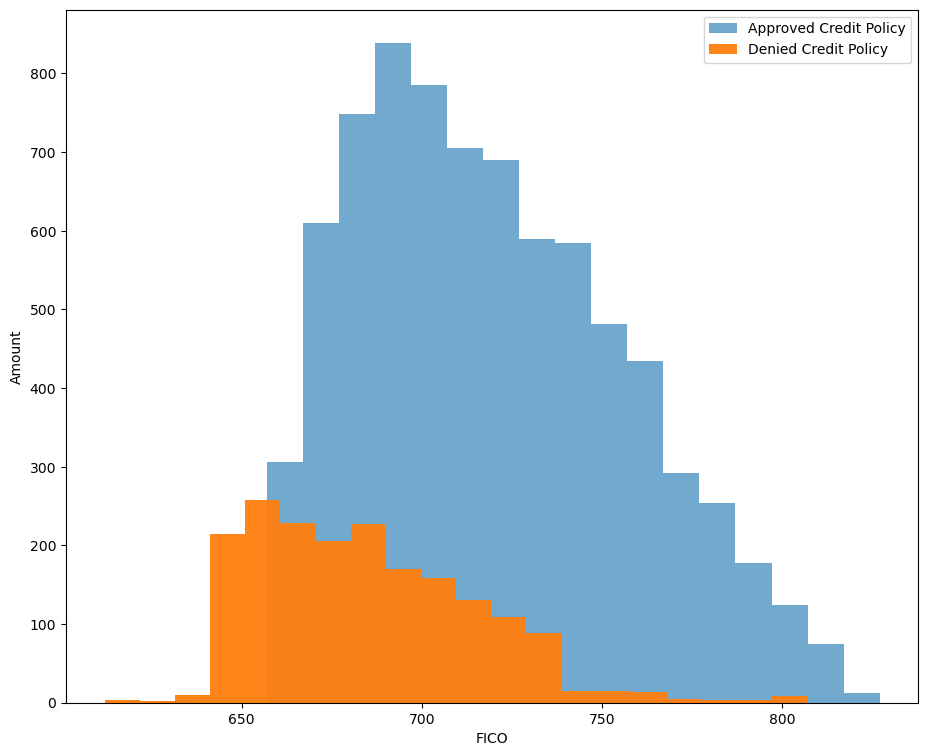

In [9]:
fig, ax = plt.subplots(figsize=(11,9))

df_loan[df_loan["credit.policy"]==1]["fico"].hist(bins=20, alpha=0.63, grid=False, label="Approved Credit Policy")
df_loan[df_loan["credit.policy"]==0]["fico"].hist(bins=20, alpha=0.95, grid=False, label="Denied Credit Policy")

ax.set_xlabel("FICO")
ax.set_ylabel("Amount")
ax.legend()


#### Not full paid relationship with FICO

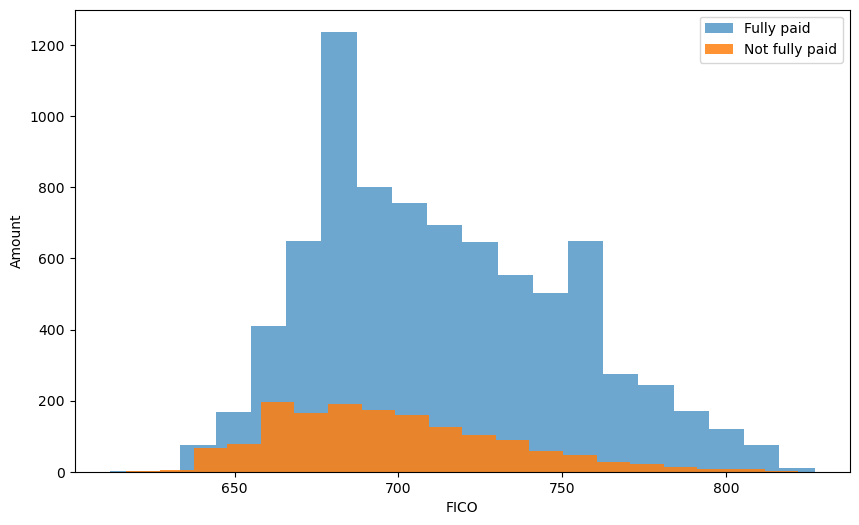

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

df_loan[df_loan["not.fully.paid"]==0]["fico"].hist(bins=20, alpha=0.65, grid=False, label="Fully paid")
df_loan[df_loan["not.fully.paid"]==1]["fico"].hist(bins=20, alpha=0.85, grid=False, label="Not fully paid")

ax.set_xlabel("FICO")
ax.set_ylabel("Amount")
ax.legend()


<Axes: xlabel='purpose', ylabel='count'>

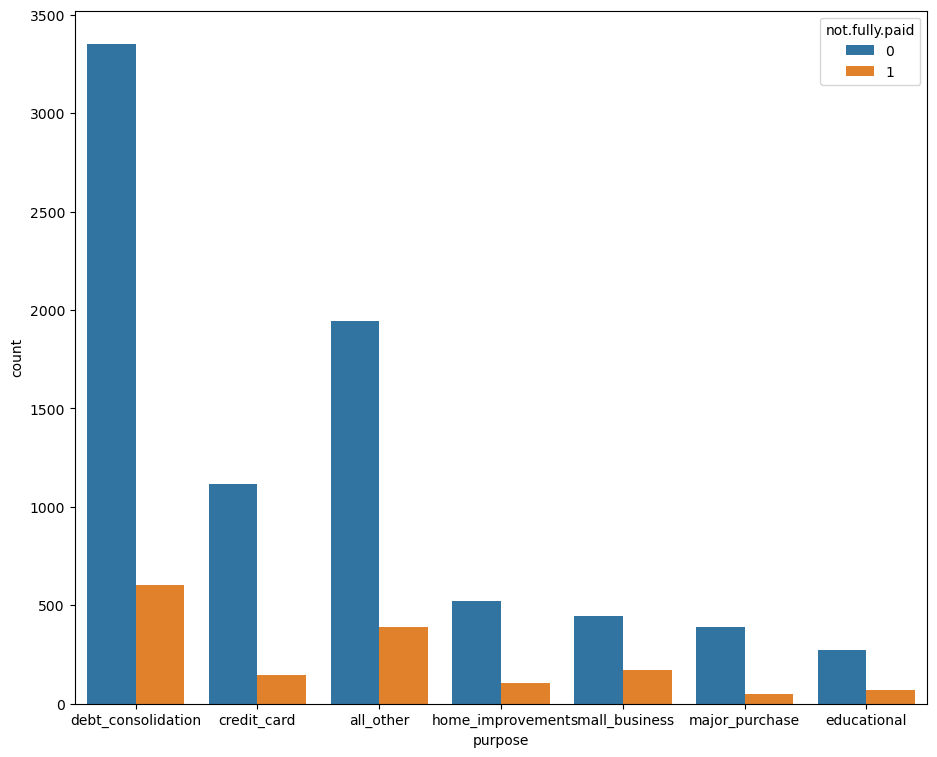

In [11]:
fig, ax = plt.subplots(figsize=(11,9))

sns.countplot(data=df_loan, x="purpose", hue="not.fully.paid")

Os dados estão desbalanceados, o que pode nos gerar problemas na modelagem, vamos checar a discrepancias entre as classes

In [12]:
print(df_loan["not.fully.paid"].value_counts())
print("\nFraudes representam {:.2f}% do dataset!\n".format((df_loan[df_loan['not.fully.paid'] == 1].shape[0] / df_loan.shape[0]) * 100))


0    8045
1    1533
Name: not.fully.paid, dtype: int64

Fraudes representam 16.01% do dataset!



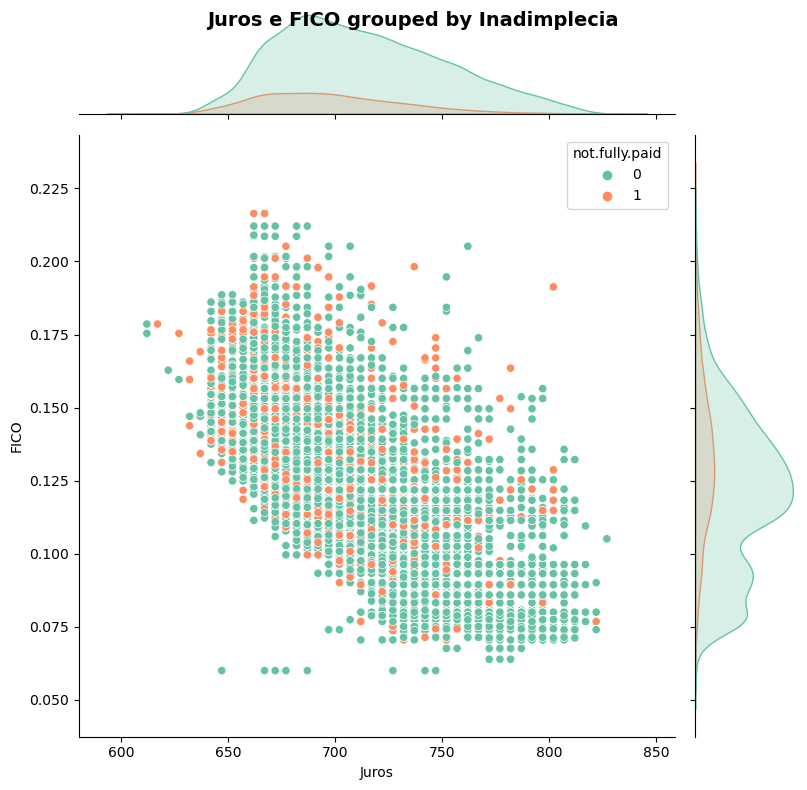

In [13]:
joint_rate_by_fico = sns.jointplot(data=df_loan, y="int.rate", x="fico", palette='Set2', hue="not.fully.paid", height=8)
joint_rate_by_fico.set_axis_labels('Juros', 'FICO')
joint_rate_by_fico.fig.suptitle('Juros e FICO grouped by Inadimplecia', weight='bold', size=14)
plt.show()

Check outliers

In [14]:
df_loan[
    (df_loan["not.fully.paid"]==1) & 
    (df_loan["int.rate"]>0.175) & (df_loan["fico"]>750)]# Outlier case 

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
9393,0,small_business,0.1913,918.02,11.149082,17.56,802,12344.0,190050,8.0,3,0,0,1


In [15]:
df_loan[
    (df_loan["not.fully.paid"]==0) & 
    (df_loan["int.rate"]<0.075) & (df_loan["fico"]<700)]# Outlier case 

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
453,1,debt_consolidation,0.060,467.45,11.042922,15.28,687,4652.041667,26044,34.5,3,0,0,0
1031,1,credit_card,0.060,231.03,11.184421,14.07,672,2910.000000,15885,46.9,1,1,0,0
1400,1,debt_consolidation,0.060,216.38,10.239960,12.09,667,2550.000000,14320,67.5,1,0,0,0
5828,1,debt_consolidation,0.060,380.27,11.350407,9.98,677,5705.041667,10844,68.6,3,1,0,0
6612,1,all_other,0.074,248.48,11.198215,0.44,697,5190.041667,666,8.5,0,1,0,0
8683,0,debt_consolidation,0.060,184.28,10.359646,7.49,647,2369.958333,7884,63.1,1,0,0,0


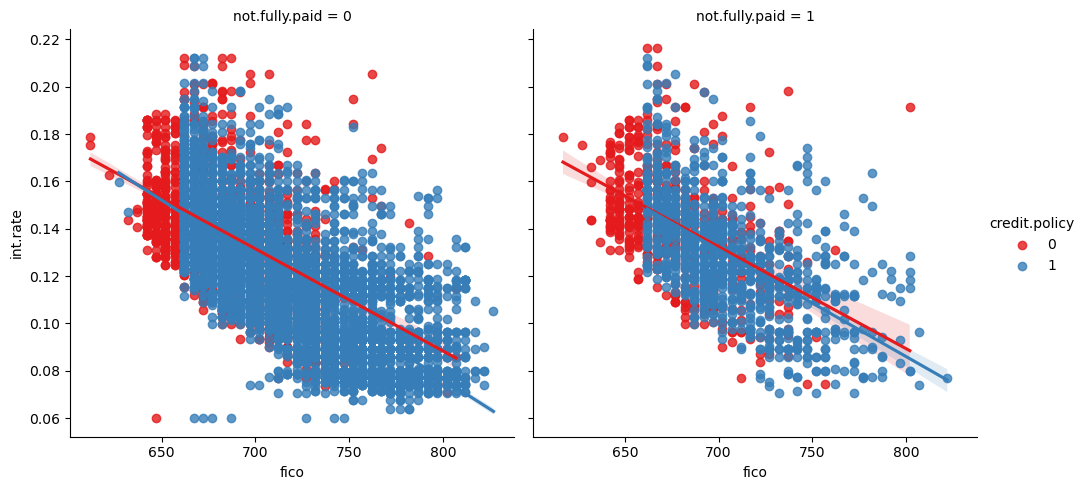

In [16]:
lmplot_rate_fico = sns.lmplot(data=df_loan, y="int.rate", x="fico", hue="credit.policy", col="not.fully.paid", palette="Set1")

# Configurando os dados

Vamos nos preparar para configurar nossos dados para o nosso modelo de classificação de florestas aleatórias!

Vamos transformar a coluna ***purpose*** em categórica.

In [17]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [165]:
df_final = pd.get_dummies(df_loan, columns = ["purpose"], drop_first = True)
df_final.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


## Divisão Treino-Teste de dados


In [168]:
features = df_final.columns[(df_final.columns != 'not.fully.paid')]

x = df_final[features]
y = df_final["not.fully.paid"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)

Function

In [115]:
def confusion_matrix_heatmap(conf_mx, cmap="Blues", t_focus=True):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]

    group_percentages = ['{0:.2%}'.format(value) for value in conf_mx.flatten()/np.sum(conf_mx)]

    labels = [f'{v1}\n\n{v3}' for v1, v3 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    off_diag_mask = [[],[]]  # mask=off_diag_mask
    if t_focus:
        off_diag_mask = np.fliplr(np.eye(*conf_mx.shape, dtype=bool))
        
    map_sns = sns.heatmap(conf_mx, annot=True, fmt="",  cmap=cmap, cbar=False,  mask=off_diag_mask)
    # map_sns.set_yticklabels(map_sns.get_yticklabels(), va='center')
    # map_sns.patch.set_facecolor('green')
    # map_sns.patch.set_edgecolor('white')
    # map_sns.patch.set_hatch('xx')

    plt.show()

def model_valid_report(model, y, pred, t_focus=True):
    conf_mx = confusion_matrix(y, pred)
    clf_report = classification_report(y, pred)

    print(conf_mx)
    print(clf_report)

    confusion_matrix_heatmap(conf_mx, cmap="Greens",  t_focus=t_focus)
     


Logistic Model 

Como os dados estão desbalanceados, podemos observar na matrix de confusão uma descrepancia entre as classes e o recall

Vamos balancear fazer o balanceamento como under and over sampling para verificar os resultados!

In [169]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
x_train_res, y_train_res = rus.fit_resample(x_train, y_train)

print(pd.Series(y_train_res).value_counts())


0    1067
1    1067
Name: not.fully.paid, dtype: int64


Vamos treinar o modelo com dados de treino e avaliar

[[1566  842]
 [ 173  293]]
              precision    recall  f1-score   support

           0       0.90      0.65      0.76      2408
           1       0.26      0.63      0.37       466

    accuracy                           0.65      2874
   macro avg       0.58      0.64      0.56      2874
weighted avg       0.80      0.65      0.69      2874



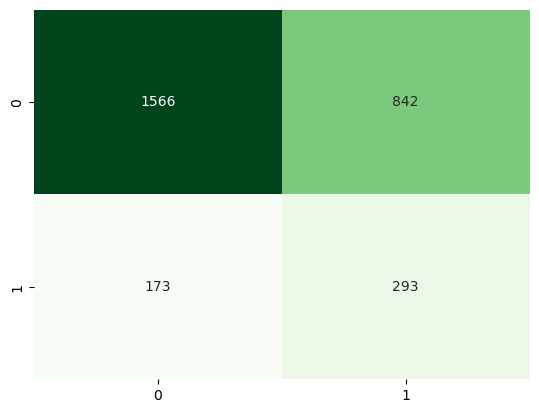

In [170]:
log_model = LogisticRegression(solver="newton-cholesky", multi_class="ovr")
log_model.fit(x_train_res, y_train_res)
preds_log= log_model.predict(x_valid)
model_valid_report(log_model, y_valid, preds_log, t_focus=False)

XGB

[0]	validation_0-auc:0.59654
[1]	validation_0-auc:0.61627
[2]	validation_0-auc:0.60363
[3]	validation_0-auc:0.62963
[4]	validation_0-auc:0.62826
[5]	validation_0-auc:0.63020
[6]	validation_0-auc:0.63043
[7]	validation_0-auc:0.63535
[8]	validation_0-auc:0.63517
[9]	validation_0-auc:0.63629
[10]	validation_0-auc:0.63870
[11]	validation_0-auc:0.63848
[12]	validation_0-auc:0.63979
[13]	validation_0-auc:0.64021
[14]	validation_0-auc:0.63964
[15]	validation_0-auc:0.63991
[16]	validation_0-auc:0.64177
[17]	validation_0-auc:0.64247
[18]	validation_0-auc:0.64270
[19]	validation_0-auc:0.64261
[20]	validation_0-auc:0.64360
[21]	validation_0-auc:0.64195
[22]	validation_0-auc:0.64282
[23]	validation_0-auc:0.64331
[24]	validation_0-auc:0.64421
[25]	validation_0-auc:0.64410
[26]	validation_0-auc:0.64480
[27]	validation_0-auc:0.64482
[28]	validation_0-auc:0.64560
[29]	validation_0-auc:0.64440
[30]	validation_0-auc:0.64513
[31]	validation_0-auc:0.64551
[32]	validation_0-auc:0.64696
[33]	validation_0-au

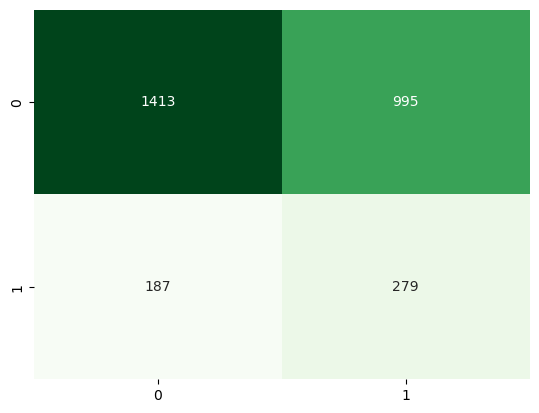

In [198]:
xgb_clf =XGBClassifier(objective="binary:logistic",eval_metric="auc", learning_rate=0.05, n_estimators=115)
xgb_clf.fit(x_train_res, y_train_res, eval_set=[(x_valid, y_valid)])

# xgb_clf.fit(x_train_res, y_train_res)

preds_log = xgb_clf.predict(x_valid)
model_valid_report(log_model, y_valid, preds_log, t_focus=False)


Check Feature Importance

In [26]:
lin_explainer = shap.LinearExplainer(log_model, x)
shap_lin = lin_explainer.shap_values(x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


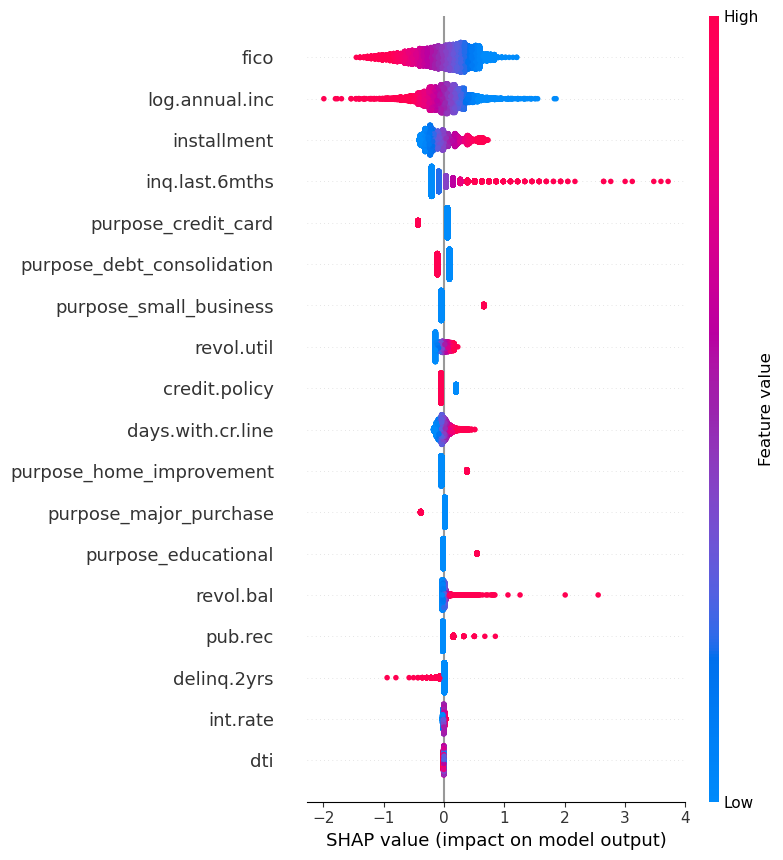

In [27]:

shap.summary_plot(shap_lin, x)

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[0][0], x_train.iloc[0])

In [29]:
# We can try to do a reverse log to figure out the salary and from the salary we get a the installment percentage
# Also try to figure out the credit amount and its relationships with the current features